In [1]:
# for rendering Latex

import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.style.use('seaborn-dark-palette')

width = 345

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

/var/folders/v1/1r3cbng93gg6xsx3ghwzpk9c0000gn/T/ipykernel_19279/691548166.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [7]:
# imports
import numpy as np
import os
import matplotlib.pyplot as plt 

import sys
sys.path.append('../')

from src.utils import load_data

DATA_DIR = '../data'
BETA_VALUES = np.sort(
    [float(x.split('fermi_')[-1]) for x in os.listdir(DATA_DIR) if x.startswith('fermi')])

print('Beta values:',len(BETA_VALUES))

Beta values: 30


## Transition to equipartition

In [2]:
# train LSTM autoencoder 

from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras import regularizers


def autoencoder_model(timesteps, n_features=64):
    sequential = Sequential()
    sequential.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
    # sequential.add(LSTM(16, activation='relu', return_sequences=True, kernel_regularizer=regularizers.L1(10e-))) 
    sequential.add(LSTM(8, activation='relu', return_sequences=False))
    sequential.add(RepeatVector(timesteps))
    sequential.add(LSTM(8, activation='relu', return_sequences=True))
    sequential.add(LSTM(32, activation='relu', return_sequences=True))
    sequential.add(TimeDistributed(Dense(n_features)))
    sequential.compile(optimizer='adam', loss='mse')
    return sequential

In [33]:
# train on first portion, when no equipartition

from utils import temporalize_data
timesteps = 5

data_train = load_data(DATA_DIR, 1.6)
X_train_portion = data_train.data_matrix[:120000] 
X_train = temporalize_data(X_train_portion, 5)

model = autoencoder_model(timesteps)
model.fit(X_train, X_train, epochs=30, batch_size=64, verbose=True)

Epoch 1/30
1875/1875 [==============================] - 8s 3ms/step - loss: 0.0174
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 8.5448e-04
Epoch 3/30
1875/1875 [==============================] - 6s 3ms/step - loss: 5.7021e-04
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 4.4775e-04
Epoch 5/30
1875/1875 [==============================] - 7s 3ms/step - loss: 3.4332e-04
Epoch 6/30
1875/1875 [==============================] - 7s 4ms/step - loss: 2.9793e-04
Epoch 7/30
1875/1875 [==============================] - 6s 3ms/step - loss: 2.7925e-04
Epoch 8/30
1875/1875 [==============================] - 6s 3ms/step - loss: 2.6135e-04
Epoch 9/30
1875/1875 [==============================] - 6s 3ms/step - loss: 2.3150e-04
Epoch 10/30
1875/1875 [==============================] - 6s 3ms/step - loss: 2.2439e-04
Epoch 11/30
1875/1875 [==============================] - 6s 3ms/step - loss: 2.0977e-04
Epoch 12/30
1875/1875 [======================

In [34]:
# use encoder to encode input trajectory data onto low-dimensional space
from keras.models import Model

encoder_model = Model(inputs=model.inputs, outputs=model.layers[1].output)
X_train_enc = encoder_model.predict(X_train)

3750/3750 [==============================] - 2s 485us/step


In [35]:
# compute max reconstruction error on train set (times range within which no equipartition obserrved, so still in the toroid manifold)

X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X), axis=1)

thresholds_train = []
for feature_idx in range(train_mae_loss.shape[1]):
    # feature_threshold = np.mean(train_mae_loss[:,feature_idx]) + np.std(train_mae_loss[:,feature_idx])
    feature_threshold = np.max(train_mae_loss[:, feature_idx])
    thresholds_train.append(feature_threshold)

max_thresholds_train = max(thresholds_train)
np.round(max_thresholds_train, 3), print(np.argmax(thresholds_train))

3750/3750 [==============================] - 3s 754us/step
63


(0.094, None)

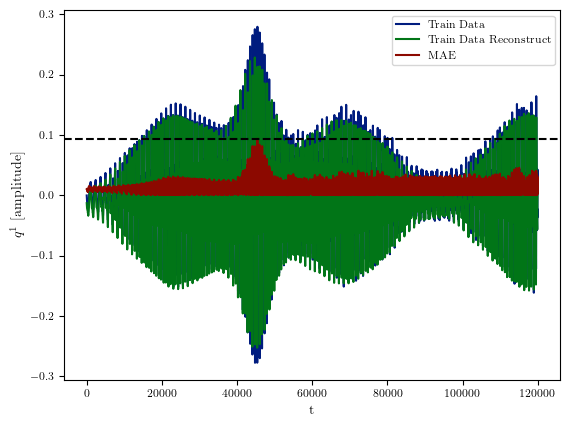

In [36]:
# visualise reconstruction error train. Note I visualise for a specific feature, being the one for which error is max

feature_list = np.arange(1, 66)

feature_idx = 63

limit = 1000000000
plt.figure()

plt.plot(X_train[:limit, 0, feature_idx], label='Train Data')
plt.plot(X_train_pred[:limit,0,feature_idx], label='Train Data Reconstruct')
plt.plot(train_mae_loss[:limit, feature_idx], label='MAE')
plt.axhline(max_thresholds_train, color='k', linestyle='--')

plt.xlabel('t')
plt.ylabel('$q^{1}$ [amplitude]')
plt.legend(loc='upper right')
plt.show()

### find phase transition

In [37]:
# test on remaining portion, where at some point equipartition is observed

data_test = load_data(DATA_DIR, 1.6)
time_test = data_test.time

X_test_portion = data_test.data_matrix[-300000:-1] 
energy_test = data_test.energy_matrix[-300000 +6:-1]  # to account for temporalisation
time_test = time_test[-300000 +6:-1]  # to account for temporalisation

X_test = temporalize_data(X_test_portion, 5)

X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

9375/9375 [==============================] - 7s 752us/step


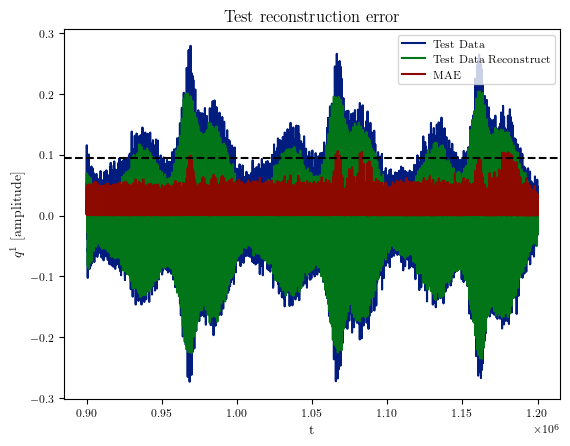

In [38]:
plt.figure()

limit = 2000000

plt.plot(time_test[:limit], X_test[:limit, 0, feature_idx],label='Test Data')
plt.plot(time_test[:limit], X_test_pred[:limit, 0, feature_idx],label='Test Data Reconstruct')
plt.plot(time_test[:limit], test_mae_loss[:limit, feature_idx], label='MAE')
plt.axhline(max_thresholds_train, color='k', linestyle='--')

# test_mae_loss_ = test_mae_loss[:limit, feature_idx]
# mask = test_mae_loss_ > max_thresholds_train 
# test_mae_loss_[mask] -= max_thresholds_train

# plt.plot(time_test[:limit], test_mae_loss_, label='err above threshold')

plt.xlabel('t')
plt.ylabel('$q^{1}$ [amplitude]')
plt.legend(loc='upper right')
plt.title(f'Test reconstruction error')
plt.show()

In [39]:
# find energy portion relative to above threshold reconstruction errror# 

def find_ranges(nums):

    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    ranges  = list(zip(edges, edges))

    # return [range for range in ranges if (range[1] - range[0] > 10)]
    return ranges

times_above_threshold = np.where(test_mae_loss[:limit, feature_idx] > max_thresholds_train)[0] + time_test[0]

ranges = find_ranges(times_above_threshold)

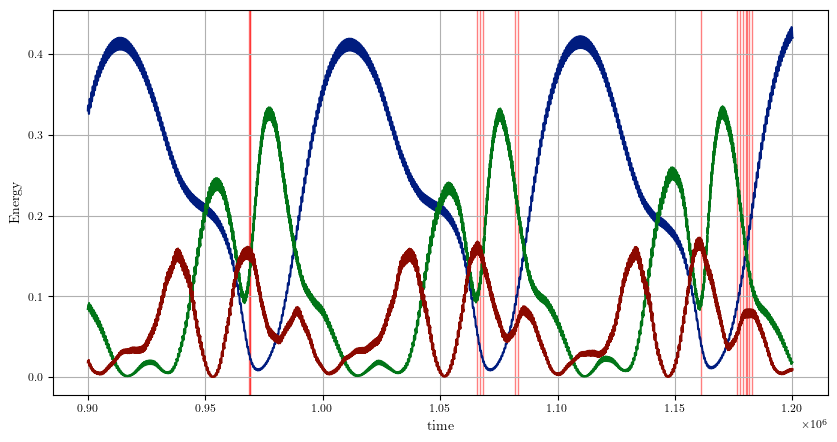

In [40]:
# find energy portion relative to above threshold reconstruction errror

fig, (ax) = plt.subplots(1, 1, figsize=(10,5))
ax.plot(time_test, energy_test[:,0], linewidth=1.5, label="Mode 1") 
ax.plot(time_test, energy_test[:,2], linewidth=1.5, label="Mode 3")
ax.plot(time_test, energy_test[:,4], linewidth=1.5, label="Mode 5")
# ax.scatter(times_above_threshold, [0.0] * len(times_above_threshold), color='red') 

# ax.axvspan(1182784, 1182798, alpha=0.5, color='red')
for r in ranges:
    ax.axvspan(r[0], r[1], alpha=0.5, color='red')

ax.set_xlabel('time')
ax.set_ylabel('Energy')
ax.grid()

### test on data for higher beta

In [41]:
data_test_beta2 = load_data(DATA_DIR, 2.0)
time_test_beta2 = data_test_beta2.time

X_test_beta2_portion = data_test_beta2.data_matrix[100000:600000] 
energy_test_beta2 = data_test_beta2.energy_matrix[100000:600000]  # to account for temporalisation
# time_test_beta2 = time_test_beta2[:300000]  # to account for temporalisation

X_test_beta2 = temporalize_data(X_test_beta2_portion, 5)

X_test_beta_2_pred = model.predict(X_test_beta2)
test_mae_loss_beta2 = np.mean(np.abs(X_test_beta_2_pred - X_test_beta2), axis=1)

15625/15625 [==============================] - 12s 764us/step


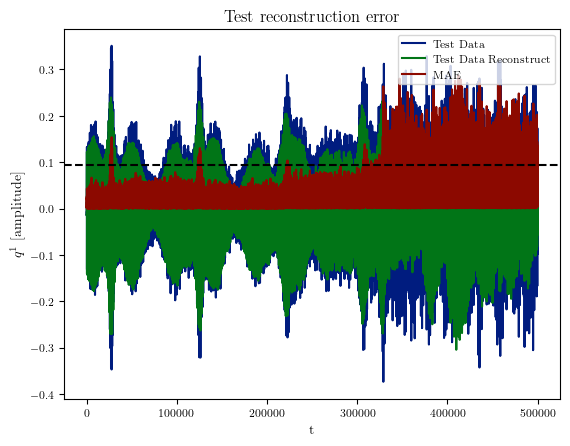

In [42]:
plt.figure()

limit = 2000000

plt.plot(X_test_beta2[:limit, 0, feature_idx],label='Test Data')
plt.plot(X_test_beta_2_pred[:limit, 0, feature_idx],label='Test Data Reconstruct')
plt.plot(test_mae_loss_beta2[:limit, feature_idx], label='MAE')
plt.axhline(max_thresholds_train, color='k', linestyle='--')

plt.xlabel('t')
plt.ylabel('$q^{1}$ [amplitude]')
plt.legend(loc='upper right')
plt.title(f'Test reconstruction error')
plt.show()

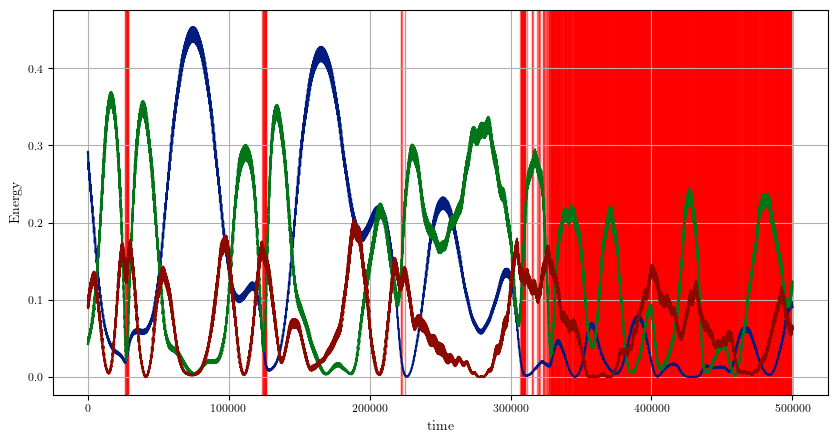

In [43]:
# find energy portion relative to above threshold reconstruction errror

times_above_threshold_beta2 = np.where(
    test_mae_loss_beta2[:limit, feature_idx] > max_thresholds_train)[0] + time_test_beta2[0]

ranges = find_ranges(times_above_threshold_beta2)

fig, (ax) = plt.subplots(1, 1, figsize=(10,5))
ax.plot(energy_test_beta2[:,0], linewidth=1.5, label="Mode 1") 
ax.plot(energy_test_beta2[:,2], linewidth=1.5, label="Mode 3")
ax.plot(energy_test_beta2[:,4], linewidth=1.5, label="Mode 5")
# ax.scatter(times_above_threshold_beta2, [0.0] * len(times_above_threshold_beta2), color='red') 

# ax.axvspan(1182784, 1182798, alpha=0.5, color='red')
for r in ranges:
    ax.axvspan(r[0], r[1], alpha=0.5, color='red')

ax.set_xlabel('time')
ax.set_ylabel('Energy')
ax.grid()